In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU
from tensorflow.keras.layers import BatchNormalization, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model, Sequential
import numpy as np

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, UpSampling2D, Concatenate
from tensorflow.keras.models import Sequential

def convolution_operation(input_layer, filters):
    conv = Conv2D(filters, kernel_size=(3, 3), padding="same", activation="relu")(input_layer)
    conv = Conv2D(filters, kernel_size=(3, 3), padding="same", activation="relu")(conv)
    return conv

def encoder(entered_input, filters=64):
    enc1 = convolution_operation(entered_input, filters)
    MaxPool1 = MaxPooling2D(strides=(2, 2))(enc1)
    return enc1, MaxPool1

def decoder(entered_input, skip, filters=64):
    Upsample = Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(entered_input)
    Connect_Skip = Concatenate()([Upsample, skip])
    out = convolution_operation(Connect_Skip, filters)
    return out

def FCNPool3(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    enc1, MaxPool1 = encoder(inputs, filters=64)
    enc2, MaxPool2 = encoder(MaxPool1, filters=128)
    enc3, MaxPool3 = encoder(MaxPool2, filters=256)

    # Decoder
    dec1 = decoder(MaxPool3, enc3, filters=256)
    dec2 = decoder(dec1, enc2, filters=128)

    # Final convolution
    outputs = Conv2DTranspose(num_classes, (2, 2), strides=2, padding="same")(dec2)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Define the input shape and number of classes
input_shape = (512, 512, 3)
num_classes = 2

# Create an instance of the FCNPool3 model with skip connections
model = FCNPool3(input_shape, num_classes)

# Compile the model
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
input_dir = '/content/drive/My Drive/image/image'
target_dir = '/content/drive/My Drive/image/mask_custom'
img_size = (512, 512)
num_classes = 2
batch_size = 8
input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith('.jpg') or fname.endswith('.png') or fname.endswith('.jpg.png')
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith('.jpg') or fname.endswith('.png') or fname.endswith('.jpg.png') and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Mounted at /content/drive
Number of samples: 265
/content/drive/My Drive/image/image/MaI14_003.jpg.png | /content/drive/My Drive/image/mask_custom11/mask_chunk_10_MaI14_003.jpg.png
/content/drive/My Drive/image/image/MaI14_004.jpg.png | /content/drive/My Drive/image/mask_custom11/mask_chunk_10_MaI14_004.jpg.png
/content/drive/My Drive/image/image/MaI14_005.jpg.png | /content/drive/My Drive/image/mask_custom11/mask_chunk_10_MaI14_005.jpg.png
/content/drive/My Drive/image/image/MaI14_006.jpg.png | /content/drive/My Drive/image/mask_custom11/mask_chunk_10_MaI14_006.jpg.png
/content/drive/My Drive/image/image/MaI14_007.jpg.png | /content/drive/My Drive/image/mask_custom11/mask_chunk_10_MaI14_007.jpg.png
/content/drive/My Drive/image/image/MaI14_008.jpg.png | /content/drive/My Drive/image/mask_custom11/mask_chunk_10_MaI14_008.jpg.png
/content/drive/My Drive/image/image/MaI14_009.jpg.png | /content/drive/My Drive/image/mask_custom11/mask_chunk_10_MaI14_009.jpg.png
/content/drive/My Drive/ima

In [ ]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            y[j] = np.where(y[j] > 0, 1, 0)  # convert to binary mask
        return x, y

In [ ]:
import random

# Split our img paths into a training, validation, and test set
val_samples = 1000
test_samples = 500
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples - test_samples]
train_target_img_paths = target_img_paths[:-val_samples - test_samples]
val_input_img_paths = input_img_paths[-val_samples - test_samples:-test_samples]
val_target_img_paths = target_img_paths[-val_samples - test_samples:-test_samples]
test_input_img_paths = input_img_paths[-test_samples:]
test_target_img_paths = target_img_paths[-test_samples:]

# Instantiate data Sequences for each split
train_gen = OxfordPets(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
test_gen = OxfordPets(batch_size, img_size, test_input_img_paths, test_target_img_paths)


In [ ]:
pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 14.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283839 sha256=2a663bc4a293797a41017e43645db1f735d89013504b546c1ec95067a742bff1
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
import tensorflow as tf
def iou_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    intersection = tf.reduce_sum(tf.multiply(y_true, y_pred))
    union = tf.reduce_sum(tf.subtract(tf.add(y_true, y_pred), tf.multiply(y_true, y_pred)))
    iou = tf.where(tf.equal(union, 0), 0.0, tf.divide(intersection, union))
    return iou

# Define IOU score metric
def iou_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    intersection = tf.reduce_sum(tf.multiply(y_true, y_pred))
    union = tf.reduce_sum(tf.subtract(tf.add(y_true, y_pred), tf.multiply(y_true, y_pred)))
    iou = tf.where(tf.equal(union, 0), 0.0, tf.divide(intersection, union))
    return 1.0 - iou

from tensorflow.keras.optimizers import SGD

# Create an instance of the SGD optimizer with desired parameters
sgd_optimizer = SGD(learning_rate=0.1, momentum=0.5)
from tensorflow.keras.preprocessing.image import load_img
# Compile the model using the SGD optimizer
model.compile(optimizer=sgd_optimizer, loss=iou_loss, metrics=iou_score)

In [ ]:
# Train the model, doing validation at the end of each epoch.
epochs = 10
model = tf.keras.models.load_model('/content/drive/My Drive/segmmodel.h5', compile=False)
model.compile(optimizer='sgd', loss=iou_loss, metrics=[iou_score])
history=model.fit(train_gen, epochs=epochs, validation_data=val_gen)

Epoch 1/10
112/112 [==============================] - 166s 1s/step - loss: 0.1325 - iou_score: 0.8675 - val_loss: 0.1167 - val_iou_score: 0.8833
Epoch 2/10
112/112 [==============================] - 114s 1s/step - loss: 0.1324 - iou_score: 0.8676 - val_loss: 0.1166 - val_iou_score: 0.8834
Epoch 3/10
112/112 [==============================] - 114s 1s/step - loss: 0.1323 - iou_score: 0.8677 - val_loss: 0.1165 - val_iou_score: 0.8835
Epoch 4/10
112/112 [==============================] - 114s 1s/step - loss: 0.1322 - iou_score: 0.8678 - val_loss: 0.1163 - val_iou_score: 0.8837
Epoch 5/10
112/112 [==============================] - 114s 1s/step - loss: 0.1320 - iou_score: 0.8680 - val_loss: 0.1162 - val_iou_score: 0.8838
Epoch 6/10
112/112 [==============================] - 114s 1s/step - loss: 0.1319 - iou_score: 0.8681 - val_loss: 0.1161 - val_iou_score: 0.8839
Epoch 7/10
112/112 [==============================] - 114s 1s/step - loss: 0.1318 - iou_score: 0.8682 - val_loss: 0.1159 - val_iou

In [ ]:
model.save('segmentationsgd.h5')
from google.colab import files

files.download('segmentationsgd.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Generate predictions for all images in the validation set

val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)

val_preds = model.predict(val_gen)

125/125 [==============================] - 32s 258ms/step


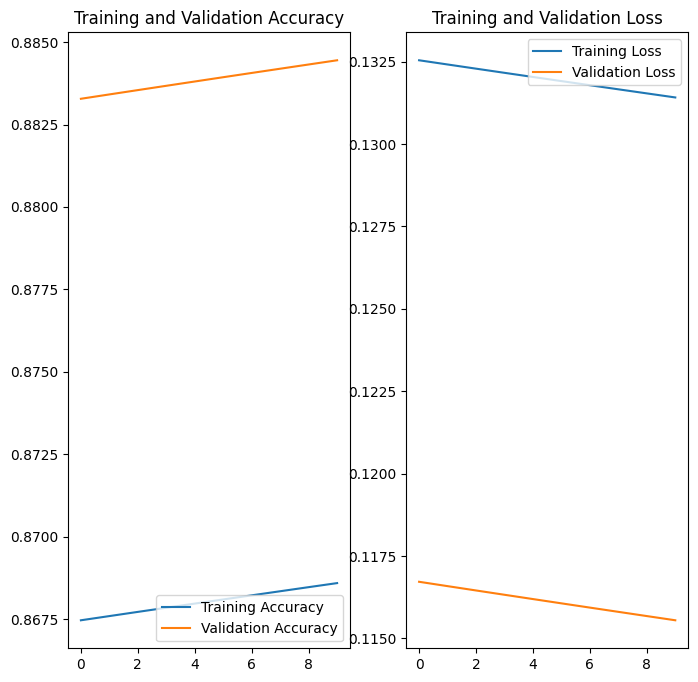

62/62 - 302s - loss: 0.1227 - iou_score: 0.8773 - 302s/epoch - 5s/step

Test accuracy: 0.8773395419120789


In [ ]:
import matplotlib.pyplot as plt
# loss and accuracy plot

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


# testing model with mlp
test_loss, test_acc = model.evaluate(test_gen, verbose=2)
print('\nTest accuracy:', test_acc)

In [ ]:
from IPython.display import Image, display
import PIL

# Define the target size of the model's input images
target_size = (512, 512)

def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    mask = PIL.Image.fromarray(np.uint8(mask.squeeze() * 255))
    mask = mask.resize(target_size)
    mask = mask.convert('RGBA')
    plt.imshow(mask)
    plt.axis('off')
    plt.show()

# Display results for validation image #10
for i in range(125):
  # Load the input image and resize it to the target size
  img = load_img(val_input_img_paths[i], target_size=target_size)

  # Load the ground-truth target mask and resize it to the target size
  mask = load_img(val_target_img_paths[i], color_mode='grayscale', target_size=target_size)

  # Display input image
  display(img)

  # Display ground-truth target mask
  img = PIL.ImageOps.autocontrast(mask)
  display(img)

  # Display mask predicted by our model
  display_mask(i)

In [ ]:
print(val_preds)

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
from google.colab import drive

drive.mount('/content/drive')
img_path = '/content/drive/My Drive/image/image/MaI14_009.jpg.png'  # Image path
model = tf.keras.models.load_model('/content/drive/My Drive/segmmodel.h5', compile=False)
model.compile(optimizer='sgd', loss=iou_loss, metrics=[iou_score])
# Load the input image
img = load_img(img_path, target_size=(512, 512,3))
img_array = img_to_array(img)
img_array = tf.keras.applications.vgg16.preprocess_input(img_array)
x = img_array.reshape((1,) + img_array.shape)
x /= 255.0

# Define a new model, Input=image, Output=intermediate representations for all layers in the previous model after the first
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs=model.input, outputs=successive_outputs)

# Run the input image through the visualization model to obtain all intermediate representations
successive_feature_maps = visualization_model.predict(x)

# Retrieve the names of the layers
layer_names = [layer.name for layer in model.layers]

for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    print(feature_map.shape)
    if len(feature_map.shape) == 4:
        # Plot feature maps for the conv / maxpool layers, not the fully-connected layers
        n_features = feature_map.shape[-1]  # Number of features in the feature map
        size = feature_map.shape[1]  # Feature map shape (1, size, size, n_features)

        # Create a grid to display the feature maps
        display_grid = np.zeros((size, size * n_features))

        # Postprocess the feature maps for visualization
        for i in range(n_features):
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            # Tile each filter into a horizontal grid
            display_grid[:, i * size: (i + 1) * size] = x

        # Display the grid
        scale = 20. / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

# Print the shape of the last feature map and the output shape of the model
print('Last feature map shape:', successive_feature_maps[-1].shape)
print('Output shape:', model.output_shape)


In [ ]:
import tensorflow as tf
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab import drive

drive.mount('/content/drive')
def iou_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    intersection = tf.reduce_sum(tf.multiply(y_true, y_pred))
    union = tf.reduce_sum(tf.subtract(tf.add(y_true, y_pred), tf.multiply(y_true, y_pred)))
    iou = tf.where(tf.equal(union, 0), 0.0, tf.divide(intersection, union))
    return iou

# Define IOU score metric
def iou_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    intersection = tf.reduce_sum(tf.multiply(y_true, y_pred))
    union = tf.reduce_sum(tf.subtract(tf.add(y_true, y_pred), tf.multiply(y_true, y_pred)))
    iou = tf.where(tf.equal(union, 0), 0.0, tf.divide(intersection, union))
    return 1.0 - iou

# Load the model
model = tf.keras.models.load_model('/content/drive/My Drive/segmmodel.h5', compile=False)
model.compile(optimizer='sgd', loss=iou_loss, metrics=[iou_score])

# Define the target size of the model's input images
target_size = (512, 512)

# Function to preprocess the image
def preprocess_image(image_path):
    image = Image.open(image_path)
    original_image = image.copy()  # Make a copy of the original image
    image = image.resize(target_size)
    image = np.array(image)
    image = image / 255.0  # Normalize the image
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image, original_image

# Function to resize segmentation mask to original image size
def resize_segmentation(segmentation_mask, original_size):
    resized_mask = cv2.resize(segmentation_mask, original_size, interpolation=cv2.INTER_NEAREST)
    return resized_mask

# Function to resize preprocessed image to original image size
def resize_image(preprocessed_image, original_size):
    resized_image = cv2.resize(preprocessed_image, original_size, interpolation=cv2.INTER_LINEAR)
    return resized_image

# Function to predict image segmentation
def predict_segmentation(image_path):
    # Preprocess the image
    image, original_image = preprocess_image(image_path)

    # Perform prediction
    prediction = model.predict(image)

    # Convert prediction to segmentation mask
    segmentation_mask = np.argmax(prediction, axis=-1)

    return segmentation_mask, original_image

# Example usage
image_path = '/content/drive/My Drive/image/image/MaI14_034.jpg.png'

# Preprocess the image and get the original image
segmentation_mask, original_image = predict_segmentation(image_path)

# Get the original image size
original_size = original_image.size

# Resize the segmentation mask to the original image size
resized_segmentation_mask = resize_segmentation(segmentation_mask[0], original_size)


# Display the original image
plt.imshow(original_image)
plt.axis('off')
plt.show()


# Display the resized segmentation mask
plt.imshow(resized_segmentation_mask, cmap='gray')
plt.axis('off')
plt.show()
